In [1]:
%%bash
echo $PYTHONPATH

In [2]:


import numpy as np
import pandas as pd
import torch
from torch import nn
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

import data_load
import data_process
import model
import train_model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from sklearn import preprocessing

DATA_PATH = "../data/Turbine_Data_Penmanshiel_11_2021-01-01_-_2021-07-01_1051.csv"
LOGS_PATH = "../data/Status_Penmanshiel_11_2021-01-01_-_2021-07-01_1051.csv"

data = data_load.load_turbine_data_without_time(DATA_PATH)
logs = data_load.load_turbine_logs_with_endtime(LOGS_PATH)
labels = data_load.get_data_label(data_load.load_turbine_data(DATA_PATH), logs)
scaler = preprocessing.StandardScaler()
data_imputer = KNNImputer(n_neighbors=10)
data = data_process.impute_data(data)
data = data_process.standardize_data(data, scaler=scaler)
print(data.shape)
data = np.array(data, dtype='float32')

(26064, 290)


In [4]:
from sklearn.model_selection import train_test_split

epochs = 3000
k = 10

i = 0
labels = np.array(labels)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.1)
# for train, test in kf.split(data):
#     ae_model = model.AutoEncoder(input_size=np.size(data, axis=1)).to(device)
#     loss = nn.MSELoss()
#     # optimizer = torch.optim.SGD(ae_model.parameters(), lr=0.001)
#     optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.0015)
#     train_labels = labels[train]
#     test_labels = labels[test]
#     X_train, X_test = data[train][train_labels==0], data[test]
#     for epoch in range(epochs):
#         print(f"\n=====epoch {epoch}/{epochs}=====")
#         train_model.train(data_x=X_train, data_y=X_train, model=ae_model, loss_fn=loss, optimizer=optimizer,
#                           batch_size=30000)
#
#     res = train_model.autoencoder_test(X_test, X_test, ae_model, 1000)
#     i += 1
#     if i == 1:
#         break

X_train = X_train[y_train == 0]

ae_model = model.AutoEncoder(input_size=np.size(data, axis=1)).to(device)
loss = nn.MSELoss()
# optimizer = torch.optim.SGD(ae_model.parameters(), lr=0.001)
optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.0015)

for epoch in range(epochs):
    print(f"\n=====epoch {epoch}/{epochs}=====")
    train_model.train(data_x=X_train, data_y=X_train, model=ae_model, loss_fn=loss, optimizer=optimizer,
                      batch_size=30000)

res = train_model.autoencoder_test(X_test, X_test, ae_model, 1000)


=====epoch 0/3000=====
loss: 0.798133  [21865/21865]

=====epoch 1/3000=====
loss: 0.796616  [21865/21865]

=====epoch 2/3000=====
loss: 0.795027  [21865/21865]

=====epoch 3/3000=====
loss: 0.792987  [21865/21865]

=====epoch 4/3000=====
loss: 0.790155  [21865/21865]

=====epoch 5/3000=====
loss: 0.786286  [21865/21865]

=====epoch 6/3000=====
loss: 0.780938  [21865/21865]

=====epoch 7/3000=====
loss: 0.773697  [21865/21865]

=====epoch 8/3000=====
loss: 0.763685  [21865/21865]

=====epoch 9/3000=====
loss: 0.749485  [21865/21865]

=====epoch 10/3000=====
loss: 0.729967  [21865/21865]

=====epoch 11/3000=====
loss: 0.704098  [21865/21865]

=====epoch 12/3000=====
loss: 0.671119  [21865/21865]

=====epoch 13/3000=====
loss: 0.631442  [21865/21865]

=====epoch 14/3000=====
loss: 0.589496  [21865/21865]

=====epoch 15/3000=====
loss: 0.556960  [21865/21865]

=====epoch 16/3000=====
loss: 0.545969  [21865/21865]

=====epoch 17/3000=====
loss: 0.535618  [21865/21865]

=====epoch 18/3000=

0.9658654946664836


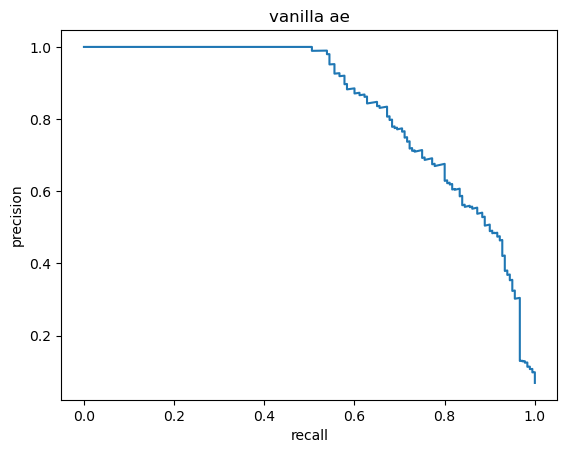

In [5]:
import sklearn.metrics as metrics

res_sorted = np.sort(res)
res_cdf = 1. * np.arange(len(res)) / (len(res) - 1)
point_color = ["red" if label == 1 else "blue" for label in y_test]
point_size = [0.1 if label == 0 else 10 for label in y_test]
# plt.hist(res, bins=200)
# plt.scatter(res, range(res.size), s=point_size, c=point_color)

fpr, tpr, _ = metrics.roc_curve(y_test, res)

precision, recall, threshold = metrics.precision_recall_curve(y_test, res)

# precision = precision[0:-3]
#
# recall = recall[0:-3]

plt.plot(recall, precision)

# print(precision, recall)

print(metrics.auc(fpr, tpr))
# print(metrics.auc(precision, recall))

# print(metrics.f1_score(test_labels, res))

# plt.scatter(res_sorted, range(res.size), s=point_size, c=point_color)
# plt.xlim(0, 150)
plt.ylabel("precision")
plt.xlabel("recall")
plt.title("vanilla ae")
plt.show()

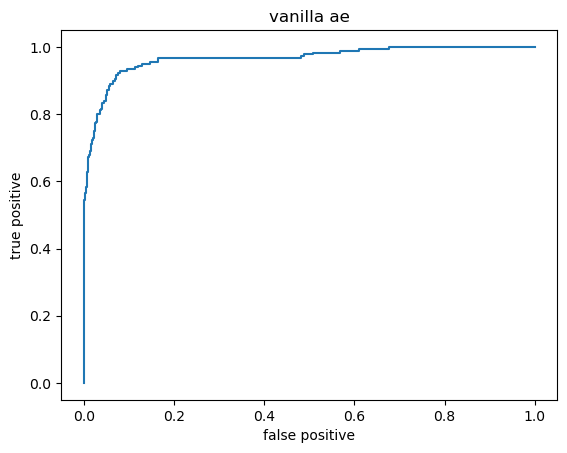

In [6]:
plt.plot(fpr, tpr)
plt.xlabel("false positive")
plt.ylabel("true positive")
plt.title("vanilla ae")
plt.show()

In [9]:
from omnixai.data.tabular import Tabular
from omnixai.explainers.tabular import CounterfactualExplainer
from torch import nn

import json

# import plotly.io as pio
# pio.renderers.default = "png"

threshold = 65

possibility = 1 / (1 + np.exp(-(res-threshold)))

# print(np.sum(possibility > 0.5))
# print(y_test.sum(), "/", y_test.size)

# print(threshold)
# def predict_fun(x):
#     distance = train_model.autoencoder_test(x, x, ae_model, x.size[0])
#     return 1 / (1 + np.exp(-(distance-threshold)))

class PredictFunc(nn.Module):
    def __init__(self, the_model, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.ae_model = the_model
        self.threshold = 65

    def forward(self, x):
        distance = train_model.autoencoder_test(x, x, self.ae_model, len(x))
        res = 1 / (1 + np.exp(-(distance-self.threshold)))
        return torch.tensor([[n] for n in res])


predict_fun = PredictFunc(ae_model)

feature_names = data_load.load_turbine_data_without_time(DATA_PATH).columns.tolist()

tabular_data = Tabular(
    X_train,
    feature_columns=feature_names
)

explainer = CounterfactualExplainer(
    training_data = tabular_data,
    predict_function=predict_fun
)

explanations = explainer.explain(X_test[y_test==1][:1])
# explanations.ipython_plot()
exp = explanations.get_explanations()
# with open("out.json", 'w') as file:
#     file.write(json.dumps(exp))
print(exp)
# exp[0].to_csv("out.csv",sep=',',index=False,header=True)
exp = exp[0]['query'].drop('label', axis=1)
# print(exp)

ValueError: Shape of passed values is (21865, 290), indices imply (21865, 299)

In [ ]:
compare = pd.concat([pd.DataFrame(X_test[:1], columns=feature_names), exp])
# scaler.inverse_transform(exp[0]['query'].drop('label', axis=1))
compare = scaler.inverse_transform(compare)
# compare.
# compare = np.append(compare, np.subtract(compare[0], compare[1]))
exp_res = pd.DataFrame(compare, columns=feature_names)
# exp_res.diff()
exp_res